In [1]:
from __future__ import print_function
from __future__ import division

from ast import literal_eval

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np
import time
import h5py
import argparse
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

import masked_networks
from tf_plus import learning_phase, batchnorm_learning_phase
from tf_plus import sess_run_dict, add_classification_losses
from tf_plus import summarize_weights
from train_supermask import make_parser, read_input_data, \
    init_model, split_and_shape

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
metaparser = argparse.ArgumentParser()
metaparser.add_argument('--experiment_name', type=str, required=True)
metaparser.add_argument('--pretrained_epochs', type=int, required=True)
metaparser.add_argument('--ckpt_idx', type=int, default=-1)
# meta_args = metaparser.parse_args()
meta_args = metaparser.parse_args([
    "--experiment_name", "control_1", "--pretrained_epochs", "55",
#     "--ckpt_idx", "-1"
])

In [3]:
def build_input_dir(seed, meta_args):
    attempt_num = 0
    experiment_name = meta_args.experiment_name
    pretrained_epochs = meta_args.pretrained_epochs

    if experiment_name == "control_3":
        input_dir = "./results/iter_lot_fc_orig/learned_supermasks_seed_{seed}_attempt_{attempt_num}/run1".format(
            seed=seed,
            attempt_num=attempt_num)

    elif experiment_name == "pretrained_supermask":
        input_dir = "./results/iter_lot_fc_orig/learned_supermasks_pre_trained_{pretrained_epochs}_epochs_seed_{seed}_{attempt_num}/run1".format(
            pretrained_epochs=pretrained_epochs,
            seed=seed,
            attempt_num=attempt_num)

    elif experiment_name == "control_1":
        epochs_num = meta_args.pretrained_epochs
        if epochs_num == 55:
            epochs_num = ''
        input_dir = "./results/iter_lot_fc_orig{epochs_num}/test_seed_{seed}".format(
            epochs_num=epochs_num,
            seed=seed)
    elif experiment_name == "control_2":
        input_dir = "./results/iter_lot_fc_orig/test_seed_{seed}/large_final_same_sign_weight_ind-1_mask_exp_none/pp7".format(
            seed=seed)
    return input_dir


parser = make_parser()
# Have a seed just to satisfy the requirements
seed = 1
input_dir = build_input_dir(seed, meta_args)

args_str = """--train_h5 ./data/mnist_train.h5 --test_h5 ./data/mnist_test.h5
--arch fc_mask --opt sgd --lr 100 --num_epochs 500 --print_every 220
--eval_every 220 --log_every 220 --save_weights --save_every 22000
--tf_seed {}
--init_weights_h5 {}
""".format(seed, input_dir).split()
args = parser.parse_args(args_str)

In [4]:
train_x, train_y = read_input_data(args.train_h5)
test_x, test_y = read_input_data(args.test_h5) # used as val for now
images_scale = np.max(train_x)
if images_scale > 1:
    print('Normalizing images by a factor of {}'.format(images_scale))
    train_x = train_x / images_scale
    test_x = test_x / images_scale


if args.test_batch_size == 0:
    args.test_batch_size = test_y.shape[0]

print('Data shapes:', train_x.shape, train_y.shape, test_x.shape, test_y.shape)
if train_y.shape[0] % args.train_batch_size != 0:
    print("WARNING batch size doesn't divide train set evenly")
if train_y.shape[0] % args.large_batch_size != 0:
    print("WARNING large batch size doesn't divide train set evenly")
if test_y.shape[0] % args.test_batch_size != 0:
    print("WARNING batch size doesn't divide test set evenly")

# build model, masked networks
if args.arch == 'fc_mask':
    model = masked_networks.build_fc_supermask(args)
else:
    raise Exception("Not prepared for non fc_mask model")
        
init_model(model, args)

sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())

Normalizing images by a factor of 255
Data shapes: (55000, 28, 28, 1) (55000,) (10000, 28, 28, 1) (10000,)
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [10]:
def sigmoid(x):
    return 1/(1+np.exp(-x))


def visualize_mask_weights(mask_layers, seed):
    num_bins = 20
    for i, mask_layer in enumerate(mask_layers):
#         plt.subplot(len(mask_layers), 2, i * 2 + 1)
#         plt.hist(mask_layer.flatten(), bins=num_bins)
#         plt.xlabel("Raw mask values at layer {}".format(i))
#         plt.subplot(len(mask_layers), 2, i * 2 + 2)
        plt.subplot(1, len(mask_layers), i + 1)
        plt.hist(mask_layer.flatten(), bins=num_bins)
        plt.xlabel("Mask at layer {}".format(i))
    plt.tight_layout()
    if not os.path.exists('results/iter_lot_fc_orig/figs'):
        os.mkdir('results/iter_lot_fc_orig/figs')
    plt.savefig(os.path.join('results/iter_lot_fc_orig/figs',
        "mask_dists_exp_{}_epochs_{}_ckpt_{}_seed_{}.png".format(
            meta_args.experiment_name, meta_args.pretrained_epochs,
            meta_args.ckpt_idx, seed
        )))
    
def get_test_accs(run_dir):
    test_accs = []
    for filename in os.listdir(run_dir):
        print()
        if 'tfevents' in filename:
            for e in tf.compat.v1.train.summary_iterator(os.path.join(
                run_dir, filename
            )):
                for v in e.summary.value:
                    if v.tag == 'eval_test_acc':
                        test_accs.append(v.simple_value)
    return np.array(test_accs)

def ccdf(data):
    s_data = np.sort(data)[::-1]
    return np.stack([s_data, np.arange(s_data.shape[0]) + 1], axis=1)

In [11]:
def run_analysis_on_seed(seed, meta_args):
    seed_info = {
        "seed": seed,
        "regular_epochs": meta_args.pretrained_epochs,
        "supermask_epochs": 0,
        "experiment_name": meta_args.experiment_name,
        "has_supermask": 0,
        "has_lth": 0,
        "test_accuracy": None,
        "ckpt_idx": meta_args.ckpt_idx,
    }

    if meta_args.experiment_name == "control_2":
        seed_info["has_lth"] = 1
    elif meta_args.experiment_name != "control_1":
        seed_info["has_supermask"] = 1
        seed_info["supermask_epochs"] = 500

    args.init_weights_h5 = build_input_dir(seed, meta_args)
    if not args.init_weights_h5.endswith('/weights'):
        h5file = os.path.join(args.init_weights_h5, 'weights')
    else:
        h5file = args.init_weights_h5

    # Unsuccessful seed, skip
    if not os.path.exists(h5file):
        print("Could not find:", h5file)
        return None

    hf_weights = h5py.File(h5file, 'r')
    all_weights = hf_weights.get('all_weights')
    print("Number of weight copies:", len(all_weights))
    init_weights_flat = all_weights[0]
    final_weights_flat = all_weights[meta_args.ckpt_idx]

    shapes = [literal_eval(s) for s in hf_weights.attrs['var_shapes'].decode('utf-8').split(';')]

    weight_values = split_and_shape(init_weights_flat, shapes)
    final_weight_values = split_and_shape(final_weights_flat, shapes)
    if seed_info["has_lth"]:
        current_mask_flat = np.array(hf_weights.get('mask_values'))
        current_mask = split_and_shape(current_mask_flat, shapes)

    hf_weights.close()

    gk = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES)
    if len(gk) > 9:
        print("You need to restart the kernel - graphkeys have been replicated" +
              " and there's no going back")

    wv_idx = 0
    for i, w in enumerate(gk):
        if seed_info["has_supermask"] or 'mask' not in w.name: # HACK for biased masks
            print('loading weights for layer {}: {}'.format(i, w.name))
            w.load(weight_values[wv_idx], session=sess)
            wv_idx += 1
    # Mask analysis
    if seed_info["has_supermask"]:
        mask_layers = [sigmoid(weights) for weights in final_weight_values[2::3]]
    elif seed_info["has_lth"]:
        mask_layers = current_mask[::2]
    else:
        mask_layers = [np.ones(weights.shape) for weights in final_weight_values[::2]]
    print("Basic info")
    all_mask_weights = []
    for mask_layer in mask_layers:
        print("Shape:", mask_layer.shape)
        print("Average fraction masked:", 1-mask_layer.mean())
        print("Min: {}, Max: {}\n".format(
            mask_layer.min(), mask_layer.max()))
        all_mask_weights.append(mask_layer.flatten())
    all_mask_weights = np.concatenate(all_mask_weights)

    seed_info["fraction_supermasked"] = 1-all_mask_weights.mean()
    print("Total average fraction masked:", seed_info["fraction_supermasked"])

    # Number of bernoulli samples. Not much difference between samples observed
    n_bern = 3
    sampled_infos = []

    for i in range(n_bern):
        DG = nx.DiGraph()
        edges = []
        nodes = set(["s", "t"])
        masked_weights = []
        sampled_info = {}

        increment = 2
        if seed_info["has_supermask"]:
            increment = 3
        for j, mask_layer in enumerate(mask_layers):
            clamped_mask = np.random.binomial(1, mask_layer)
            masked_weights.append(clamped_mask * final_weight_values[j * increment])

            # Don't do graph processing for first layer, too many edges
            if j == 0:
                continue
            for row_ind, row in enumerate(clamped_mask):
                for col_ind, val in enumerate(row):
                    in_node = "{}_{}".format(j, row_ind)
                    out_node = "{}_{}".format(j + 1, col_ind)
                    nodes.add(in_node)
                    nodes.add(out_node)

                    if j == 1:
                        edges.append(["s", in_node])
                    elif j == len(mask_layers) - 1:
                        edges.append([out_node, "t"])

                    if val == 1:
                        edge = [in_node, out_node]
                        DG.add_edge(*edge, capacity=abs(val))
        DG.add_nodes_from(nodes)
        DG.add_edges_from(edges, weight=1, capacity=10e10)
        all_masked_weights = np.concatenate([
            masked_weight.flatten() for masked_weight in masked_weights
        ])
        # Just get weight matrices
        all_init_weights = np.concatenate([
            init_weight.flatten() for init_weight in weight_values[::increment]
        ])

        out_degree_dist = np.array([pair[1] for pair in DG.out_degree()])
        in_degree_dist = np.array([pair[1] for pair in DG.in_degree()])
        out_deg_ccdf = ccdf(out_degree_dist)
        in_deg_ccdf = ccdf(in_degree_dist)
        if i == 0:
            plt.subplot(1, 2, 1)
            plt.scatter(in_deg_ccdf[:, 1], in_deg_ccdf[:, 0], label='In degree')
            plt.scatter(out_deg_ccdf[:, 1], out_deg_ccdf[:, 0], label='Out degree')
            plt.xlabel("Rank")
            plt.ylabel("Degree rank CCDF")
            plt.legend()
    #         plt.show()
            plt.subplot(1, 2, 2)
            plt.scatter(in_degree_dist, out_degree_dist)
            plt.xlabel("In degree dist")
            plt.ylabel("Out degree dist")
            plt.tight_layout()
            plt.savefig(os.path.join('results/iter_lot_fc_orig/figs',
                "degree_dists_exp_{}_epochs_{}_ckpt_{}_seed_{}.png".format(
            meta_args.experiment_name, meta_args.pretrained_epochs,
            meta_args.ckpt_idx, seed)))
            plt.show()

        # Properties
        G = nx.Graph(DG)
        sampled_info["out_degree_mean"] = out_degree_dist.mean()
        sampled_info["out_degree_std"] = out_degree_dist.std()
    #         print("Mean and std of out degree:", out_degree_dist.mean(),
    #                out_degree_dist.std())
    #         print("Average diameter:", nx.average_shortest_path_length(G)) # not meaningful
    #         print("Approx Connectivity:", nx.node_connectivity(G)) # usually 40-43
        sampled_info["maximum_flow"] = nx.maximum_flow(G, "s", "t")[0]
    #         print("Maximum flow:", nx.maximum_flow(G, "s", "t")[0])

        sampled_info["weights_mean"] = all_mask_weights.mean()
        sampled_info["weights_std"] = all_mask_weights.std()
    #         print("Weights variance, absolute mean", all_mask_weights.std(),
    #               np.absolute(all_mask_weights).mean())

        # Best generalization bounds
        d = len(masked_weights)  # number of layers
        m = train_y.shape[0]  # length of the dataset
        # pacbayes.orig, pacbayes.flatness, pacbayes.init
        sigma = 1  # TODO: Not correct - need to calculate it
        all_weights_dist = all_masked_weights - all_init_weights
        def pacbayes_bound(vec):
            return np.power(np.linalg.norm(vec), 2) / (4 * sigma ** 2) + \
                np.log(m / sigma) + 10
        sampled_info["pacbayes.orig"] = pacbayes_bound(all_masked_weights)
        sampled_info["pacbayes.init"] = pacbayes_bound(all_weights_dist)
        sampled_info["pacbayes.flatness"] = 1 / sigma ** 2
    #         print("pacbayes.orig", pacbayes_bound(all_masked_weights))
    #         print("pacbayes.init", pacbayes_bound(all_weights_dist))
    #         print("pacbayes.flatness", 1 / sigma ** 2)
        # path.norm.over.margin
        # path.norm
        # fro.dist
        dist_frob_norm = np.linalg.norm(all_weights_dist)
        sampled_info["fro.dist"] = dist_frob_norm.sum()
    #         print("fro.dist", dist_frob_norm.sum())
        # sum.of.fro
        frob_norm = np.linalg.norm(all_masked_weights)
        sampled_info["log.sum.of.fro"] = np.log(frob_norm).sum() / d + np.log(d)
    #         print("log.sum.of.fro", np.log(frob_norm).sum() / d + np.log(d))
        sampled_infos.append(sampled_info)
    for sampled_info in sampled_infos:
        for key in sampled_info:
            if key not in seed_info:
                seed_info[key] = sampled_info[key] / n_bern
            else:
                seed_info[key] += sampled_info[key] / n_bern
    # Visualize and save img of mask weight distribution
    visualize_mask_weights(mask_layers, seed)

    seed_info["test_accuracy"] = get_test_accs(args.init_weights_h5).max()
    for key in seed_info:
        print(key, seed_info[key])
    return seed_info

Number of weight copies: 103
loading weights for layer 0: sequential_network/fc_1/kernel:0
loading weights for layer 1: sequential_network/fc_1/bias:0
loading weights for layer 3: sequential_network/fc_2/kernel:0
loading weights for layer 4: sequential_network/fc_2/bias:0
loading weights for layer 6: sequential_network/fc_3/kernel:0
loading weights for layer 7: sequential_network/fc_3/bias:0
Basic info
Shape: (784, 300)
Average fraction masked: 0.0
Min: 1.0, Max: 1.0

Shape: (300, 100)
Average fraction masked: 0.0
Min: 1.0, Max: 1.0

Shape: (100, 10)
Average fraction masked: 0.0
Min: 1.0, Max: 1.0

Total average fraction masked: 0.0


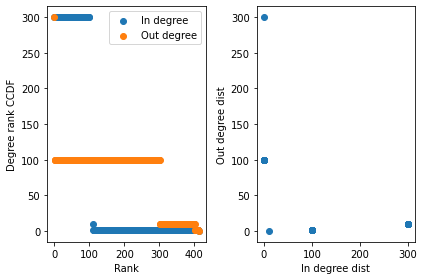











seed 1
regular_epochs 55
supermask_epochs 0
experiment_name control_1
has_supermask 0
has_lth 0
test_accuracy 0.9836000204086304
ckpt_idx -1
fraction_supermasked 0.0
out_degree_mean 75.99514563106796
out_degree_std 41.82145331068286
maximum_flow 1000.0
weights_mean 1.0
weights_std 0.0
pacbayes.orig 862.5493067267712
pacbayes.init 678.2796483011246
pacbayes.flatness 1.0
fro.dist 51.27824333328551
log.sum.of.fro 2.4522189321445653
Could not find: ./results/iter_lot_fc_orig/test_seed_2/weights
Could not find: ./results/iter_lot_fc_orig/test_seed_3/weights
Could not find: ./results/iter_lot_fc_orig/test_seed_4/weights
Could not find: ./results/iter_lot_fc_orig/test_seed_5/weights
Could not find: ./results/iter_lot_fc_orig/test_seed_6/weights
Could not find: ./results/iter_lot_fc_orig/test_seed_7/weights
Could not find: ./results/iter_lot_fc_orig/test_seed_8/weights
Could not find: ./results/iter_lot_fc_orig/test_seed_9/weights
Could not find: ./results/iter_lot_fc_orig/test_seed_

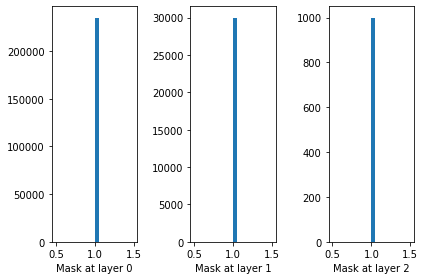

In [12]:
seed_infos = []

for seed in range(1, 11):
    seed_info = run_analysis_on_seed(seed, meta_args)
    if seed_info is not None:
        seed_infos.append(seed_info)
    
df = pd.DataFrame(seed_infos)

In [8]:
df

,seed,regular_epochs,supermask_epochs,experiment_name,has_supermask,has_lth,test_accuracy,ckpt_idx,fraction_supermasked,out_degree_mean,out_degree_std,maximum_flow,weights_mean,weights_std,pacbayes.orig,pacbayes.init,pacbayes.flatness,fro.dist,log.sum.of.fro
0,1,55,0,control_1,0,0,0.9836,-1,0.0,75.995146,41.821453,1000.0,1.0,0.0,862.549307,678.279648,1.0,51.278243,2.452219


In [9]:
df.to_csv('results/iter_lot_fc_orig/results_summary_{}_{}_{}.csv'.format(
    meta_args.experiment_name, meta_args.pretrained_epochs,
    meta_args.ckpt_idx))

# Analyzing the percentile-based pruning mask

This code looks at the mask you get when you filter the weights by percentile for the purpose of lottery-ticket hypothesis system pruning and retraining.

You should NOT run this with the supermask models

In [196]:
args.method = 'large_final_same_sign'
args.prev_weights = args.init_weights_h5
args.output_dir = args.init_weights_h5
assert('weights' not in args.output_dir)
args.prune_base = "0.8,0.9"
args.prune_power = 1
args.layer_cutoff = "4,6"
args.seed = args.tf_seed
args.final_weight_interpolation = 1
args.final_weights_ind = -1

In [197]:
args.init_weights_h5

'./results/iter_lot_fc_orig/learned_supermasks_seed_1_attempt_0/run1'

In [198]:
preproc_cmd = (
    'python get_weight_init.py --method ' + args.method +
    ' --weights_h5 ' + args.prev_weights + '/weights' +
    ' --output_h5 ' + args.output_dir + '/init_weights' +
    ' --prune_base ' + args.prune_base +
    ' --prune_power ' + str(args.prune_power) +
    ' --layer_cutoff ' + args.layer_cutoff + 
    ' --seed ' + str(args.seed) +
    ' --final_weight_interpolation ' + str(args.final_weight_interpolation) +
    ' --final_weights_ind ' + str(args.final_weights_ind))
# os.system(preproc_cmd)
preproc_cmd

'python get_weight_init.py --method large_final_same_sign --weights_h5 ./results/iter_lot_fc_orig/learned_supermasks_seed_1_attempt_0/run1/weights --output_h5 ./results/iter_lot_fc_orig/learned_supermasks_seed_1_attempt_0/run1/init_weights --prune_base 0.8,0.9 --prune_power 1 --layer_cutoff 4,6 --seed 1 --final_weight_interpolation 1 --final_weights_ind -1'

In [200]:
import subprocess
proc_out = subprocess.run(preproc_cmd.split(), capture_output=True)

In [201]:
print(proc_out.stdout.decode('utf-8'))
print(proc_out.stderr.decode('utf-8'))

==prune percentiles are: 
[19.999999999999996, 0, 19.999999999999996, 0, 9.999999999999998, 0]
==no mask exists - generating first mask

2021-06-01 02:27:18.675506: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
get_weight_init.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prune_num = np.int(np.sum(cur_mask) * percentile / 100)



In [202]:
if not args.init_weights_h5.endswith('/init_weights'):
    preproc_h5file = os.path.join(args.init_weights_h5, 'init_weights')
else:
    preproc_h5file = args.init_weights_h5
preproc_hf_weights = h5py.File(preproc_h5file, 'r')

In [203]:
mask_flat = np.array(preproc_hf_weights.get('mask_values'))
print(mask_flat.shape)
print(init_weights_flat.shape)

(532810,)
(532810,)


In [124]:
mask_values = split_and_shape(mask_flat, shapes)

In [204]:
if len(mask_values) == 9:
    raise Exception("this code should NOT be used with supermask")

Exception: this code should NOT be used with supermask

In [185]:
print("Basic info")
all_mask_weights = []
for mask_layer in mask_values:
    print("Shape:", mask_layer.shape)
    print("Average fraction masked:", 1 - mask_layer.mean())
    print("Min: {}, Max: {}\n".format(
        mask_layer.min(), mask_layer.max()))
    all_mask_weights.append(mask_layer.flatten())
all_mask_weights = np.concatenate(all_mask_weights)
print("Total average fraction masked:", 1-all_mask_weights.mean())

Basic info
Shape: (784, 300)
Average fraction masked: 0.19999574829931976
Min: 0.0, Max: 1.0

Shape: (300,)
Average fraction masked: 0.0
Min: 1.0, Max: 1.0

Shape: (784, 300)
Average fraction masked: 0.19999574829931976
Min: 0.0, Max: 1.0

Shape: (300, 100)
Average fraction masked: 0.0
Min: 1.0, Max: 1.0

Shape: (100,)
Average fraction masked: 0.08999999999999997
Min: 0.0, Max: 1.0

Shape: (300, 100)
Average fraction masked: 0.0
Min: 1.0, Max: 1.0

Total average fraction masked: 0.1772550866616428
